ZINDI Auto-Insurance challenge by INDABAX GHANA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [3]:
import pandas as pd 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import seaborn as sns 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

Load the Data

In [4]:
train = pd.read_csv('/content/drive/My Drive/ZINDI Hackthon/Train.csv')
test = pd.read_csv('/content/drive/My Drive/ZINDI Hackthon/Test.csv')

In [5]:
y_train = train['target'].values

In [ ]:
#the 'AGE' column has some anormal values
train.describe().style.background_gradient(cmap='RdPu')

,Age,No_Pol,target
count,12079.000000,12079.000000,12079.000000
mean,42.234539,1.307227,0.120457
std,97.492565,0.733085,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


In [ ]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,14-05-10,13-05-11,Male,30,14-05-10,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,29-11-10,28-11-11,Female,79,29-11-10,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,21-03-10,20-03-11,Male,43,21-03-10,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,21-08-10,20-08-11,Male,2,21-08-10,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,29-08-10,31-12-10,Entity,20,29-08-10,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [ ]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,23-10-10,22-10-11,Female,46,23-10-10,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,14-10-10,13-10-11,Male,32,14-10-10,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,29-08-10,28-08-11,Female,45,29-08-10,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,13-06-10,12-06-11,Female,58,13-06-10,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,01-07-10,30-06-11,NaN,120,01-07-10,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


Check for Null values

In [ ]:
#drop 'ID' since its not useful for analysis or machine learning
#'First transaction Date' and 'Policy start Date' are both the same
#Intuitively, the 'subject car color', 'car category' columns should be dropped as they do not give much information
train.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     359
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3738
Subject_Car_Colour        6962
Subject_Car_Make          2476
LGA_Name                  6476
State                     6488
ProductName                  0
target                       0
dtype: int64

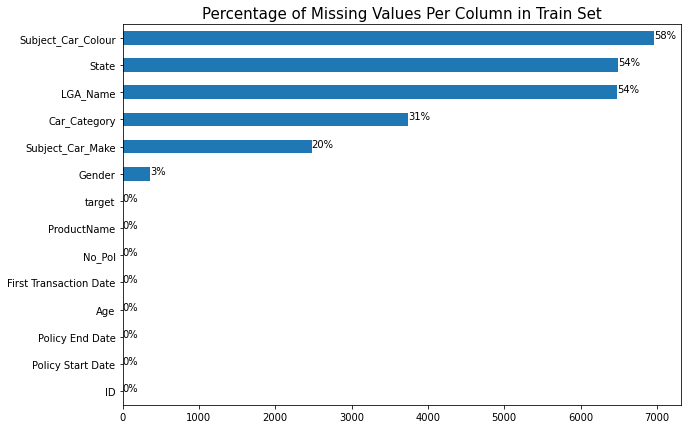

In [ ]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height = p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

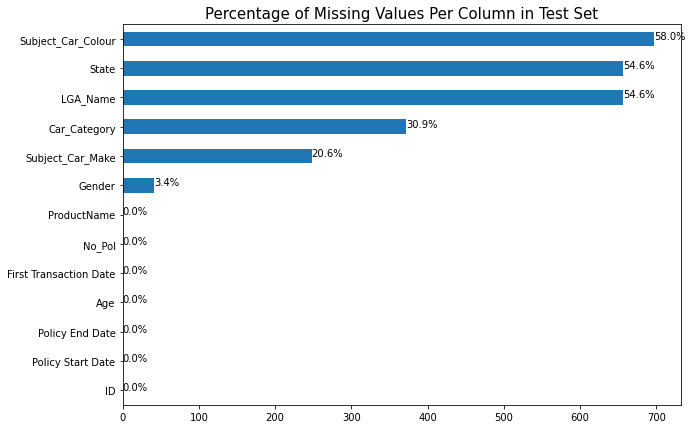

In [ ]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

SOME BASIC EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


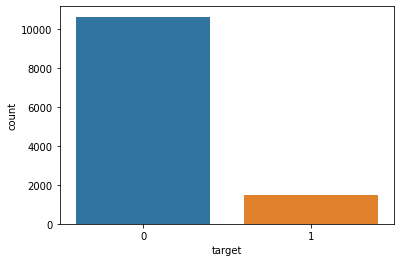

In [ ]:
#target variable
#the plot is imbalanced
sns.countplot(train.target)

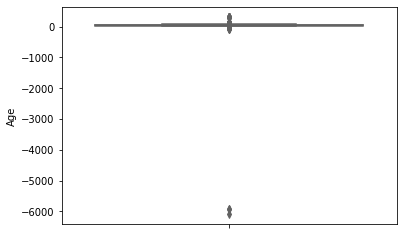

In [ ]:
#the AGE column has lots of inaccurate values, this would be corrected shortly
sns.boxplot(y='Age', data=train, palette='Accent')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


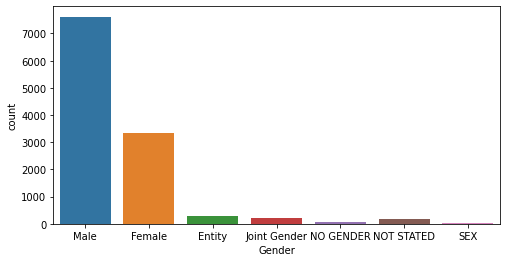

In [ ]:
#Gender column
#the Gender column also has some issues which we would need to correct
plt.figure(figsize=(8,4))
sns.countplot(train.Gender)

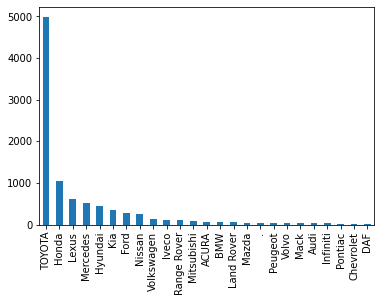

In [ ]:
#Car make column is also imbalanced
train['Subject_Car_Make'].value_counts()[:25].plot(kind='bar')

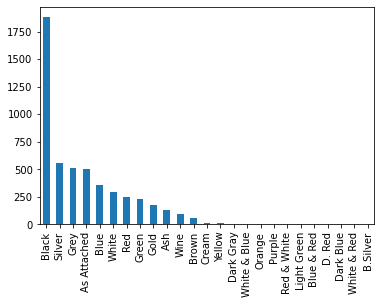

In [ ]:
#this is also imbalanced
train['Subject_Car_Colour'].value_counts()[:25].plot(kind='bar')

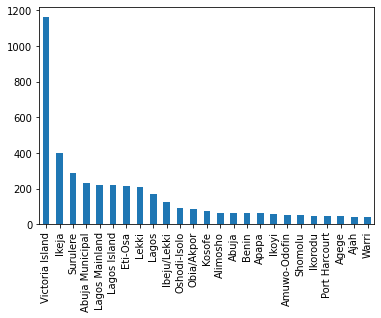

In [ ]:
train['LGA_Name'].value_counts()[:25].plot(kind='bar')

<Figure size 1440x2160 with 0 Axes>

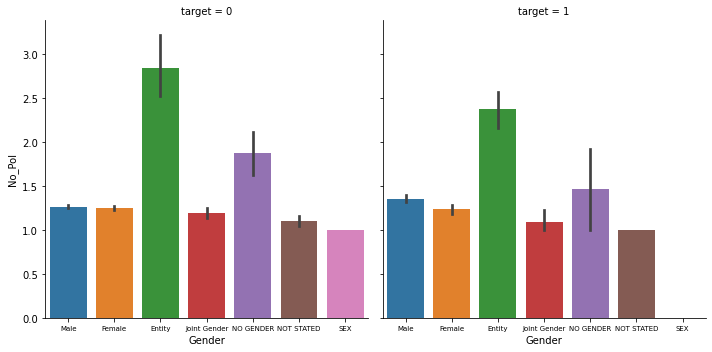

In [ ]:
#showing the number of policies for each gender and target value
plt.figure(figsize=(20,30))
ax = sns.catplot(x="Gender", y="No_Pol",col="target", data=train, kind="bar")
ax.set_xticklabels(fontsize=7)
plt.tight_layout()
plt.show()

In [6]:
#let's drop some columns we won't be needing
y_train = train.target
train.drop(columns=['ID', 'First Transaction Date'], inplace=True)

#drop the columns in the test set so that we can have equal columns on both tables
test_ID = test['ID']
test.drop(columns=['ID', 'First Transaction Date'], inplace=True)
len(train.columns), len(test.columns)

(12, 11)

In [ ]:
#length of the TRAIN & TEST set
train.shape[0], test.shape[0]

(12079, 1202)

Combine the Train & Test set for easy pre-processing

In [7]:
#let's join the train & test files so we can preprocess them jointly
#also get the no. of rows for the Train set so we can seperate them later on
train_shape = train.shape[0]
all_data = pd.concat([train, test], ignore_index=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 12)


In [ ]:
all_data.head()

,Policy Start Date,Policy End Date,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,14-05-10,13-05-11,Male,30,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,29-11-10,28-11-11,Female,79,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,21-03-10,20-03-11,Male,43,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,21-08-10,20-08-11,Male,2,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
4,29-08-10,31-12-10,Entity,20,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Policy Start Date   13281 non-null  object 
 1   Policy End Date     13281 non-null  object 
 2   Gender              12881 non-null  object 
 3   Age                 13281 non-null  int64  
 4   No_Pol              13281 non-null  int64  
 5   Car_Category        9171 non-null   object 
 6   Subject_Car_Colour  5622 non-null   object 
 7   Subject_Car_Make    10557 non-null  object 
 8   LGA_Name            6149 non-null   object 
 9   State               6137 non-null   object 
 10  ProductName         13281 non-null  object 
 11  target              12079 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


In [8]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol', 'target']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Policy Start Date   13281 non-null  datetime64[ns]
 1   Policy End Date     13281 non-null  datetime64[ns]
 2   Gender              12881 non-null  category      
 3   Age                 13281 non-null  int64         
 4   No_Pol              13281 non-null  int64         
 5   Car_Category        9171 non-null   category      
 6   Subject_Car_Colour  5622 non-null   category      
 7   Subject_Car_Make    10557 non-null  category      
 8   LGA_Name            6149 non-null   category      
 9   State               6137 non-null   category      
 10  ProductName         13281 non-null  category      
 11  target              12079 non-null  float64       
dtypes: category(7), datetime64[ns](2), float64(1), int64(2)
memory usage: 646.9 KB


In [9]:
#modify the Gender column
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':'Other', 'NaN': 'Other'}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

In [10]:
#there are 60 values with 1s as target that have NaN Gender, 
# we have to find a way to retain them as the target is imbalanced
all_data[(all_data['Gender'].isna()) & (all_data['target'] == 1.0)].shape

(60, 12)

In [11]:
all_data['Gender'].fillna('Other', inplace=True)

Number of Unique values per categorical column

In [ ]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

Gender
['Male' 'Female' 'Other'] 

Car_Category
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Saloon', 'JEEP', 'Motorcycle', 'Truck', ..., 'Shape Of Vehicle Chasis',
                          'Sedan', 'Station 4 Wheel', 'Tipper Truck'] 

Subject_Car_Colour
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['Black', 'Grey', 'Red', 'As Attached', ..., 'Beige Mitalic',
                          'Light Gray', 'Blue Sky', 'Red Maroon'] 

Subject_Car_Make
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['TOYOTA', 'REXTON', 'Lexus', 'Hyundai', ..., 'Buik', 'COMMANDER', 'Bajaj',
                          'Datsun'] 

LGA_Name
[NaN, 'Lagos', 'Ikeja', 'Badagry', 'Eti-Osa', .

Fill in the missing values

In [12]:
# Fill in missing values
# For cat cols and date cols, fill in with mode, and for num cols fill in with 50
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

# Confirm that there aren't any missing values
all_data.isna().sum()

Policy Start Date     0
Policy End Date       0
Gender                0
Age                   0
No_Pol                0
Car_Category          0
Subject_Car_Colour    0
Subject_Car_Make      0
LGA_Name              0
State                 0
ProductName           0
target                0
dtype: int64

Feature Engineering

In [13]:
# Extract date features from the date columns
for col in ['Policy Start Date', 'Policy End Date']:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,Policy Start Date,Policy End Date,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday
0,2010-05-14,2011-05-13,Male,30,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,2010,5,14,2011,5,13
1,2010-11-29,2011-11-28,Female,79,1,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,1.0,2010,11,29,2011,11,28
2,2010-03-21,2011-03-20,Male,43,1,Saloon,Red,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,2010,3,21,2011,3,20
3,2010-08-21,2011-08-20,Male,2,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,CarSafe,0.0,2010,8,21,2011,8,20
4,2010-08-29,2010-12-31,Other,20,3,Saloon,Black,TOYOTA,Lagos,Lagos,Muuve,1.0,2010,8,29,2010,12,31


In [14]:
#we can drop the 'policy Start & End dates as we would not be needing them anylonger
all_data.drop(columns=['Policy Start Date', 'Policy End Date'], inplace=True)

In [ ]:
#the 'Age' column has some anormal values like -51, 1, 140, -6099, -76
all_data.Age.unique()

array([   30,    79,    43,     2,    20,    37,    40,    71,    58,
          45,    51,   120,    38,    81,    69,    31,    70,    34,
           1,    41,    47,    36,    46,    48,    39,    63,    42,
          27,    64,    50,    53,    33,    23,    32,    59,    60,
          52,    54,    44,    11,    78,    28,    29,    57,    12,
          65,    35,    73,    56,    55,    26,    49,    18,    14,
          62,    25,    61,    72,    82,    67,     7,    10,    68,
          21,    76,    24,    66,     3,    93,    22,    77,    19,
          80,     9,     6,   -76,    -2,    89,    74,    75,    84,
          16,    90,   140,     8,     5,    13,    86,    15,   320,
         -12,    83,    85, -6099, -5939,     4,   -22,   144,   112,
          17,     0,    88,   -27,    87,   133,   102,   -51,   128,
         -26,   100])

In [15]:
#correct the anormaly in the AGE column
#we use RANDOM to avoid the AGE being centered around a particular value
#you should set a SEED value so that you get the same value everytime
from random import randint
import random

random.seed(1)

def age(x):
    if x < 18:
        return randint(18, 49)
    elif x > 89:
        return randint(50, 89)
    else:
        return x

all_data['Age'] = all_data.Age.apply(age)
all_data.Age.unique()

array([30, 79, 43, 26, 20, 37, 40, 71, 58, 45, 51, 86, 38, 81, 69, 31, 70,
       34, 22, 41, 47, 36, 46, 48, 57, 39, 63, 42, 27, 64, 50, 53, 33, 23,
       32, 59, 60, 52, 54, 78, 44, 28, 56, 29, 19, 65, 35, 74, 73, 77, 55,
       49, 18, 67, 62, 25, 61, 72, 82, 87, 84, 68, 21, 76, 24, 85, 66, 75,
       80, 89, 83, 88])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


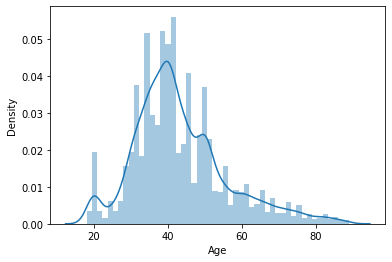

In [16]:
# #view age distribution
sns.distplot(all_data['Age'], hist=True, kde=True)

In [17]:
#cut the ages into different BINS
bins = [17, 25, 40, 60, 90]
group_names = ['Youth', 'YoungAdult', 'MiddleAged', 'Senior']

all_data['Age'] = pd.cut(all_data.Age, bins, labels=group_names)
all_data['Age'].unique()

['YoungAdult', 'Senior', 'MiddleAged', 'Youth']
Categories (4, object): ['Youth' < 'YoungAdult' < 'MiddleAged' < 'Senior']

In [18]:
#do not drop any NaN, restart
all_data.dropna(inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13281 entries, 0 to 13280
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Gender                  13281 non-null  object  
 1   Age                     13281 non-null  category
 2   No_Pol                  13281 non-null  int64   
 3   Car_Category            13281 non-null  category
 4   Subject_Car_Colour      13281 non-null  category
 5   Subject_Car_Make        13281 non-null  category
 6   LGA_Name                13281 non-null  category
 7   State                   13281 non-null  category
 8   ProductName             13281 non-null  category
 9   target                  13281 non-null  float64 
 10  Policy Start Dateyear   13281 non-null  int64   
 11  Policy Start Datemonth  13281 non-null  int64   
 12  Policy Start Dateday    13281 non-null  int64   
 13  Policy End Dateyear     13281 non-null  int64   
 14  Policy End Datemonth  

Split the dataset back into Training and Testing

In [19]:
#split the DF
train_df = all_data[:train_shape]
test_df = all_data[train_shape:]

#drop the tARGET column in the train & test set
train_df.drop(columns=['target'], inplace=True)
test_df.drop(columns=['target'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#confirm that the inputs and targets have the same length
train_df.shape, y_train.shape

((12079, 15), (12079,))

In [ ]:
train_df.head()

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday
0,Male,YoungAdult,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,2010,5,14,2011,5,13
1,Female,Senior,1,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,2010,11,29,2011,11,28
2,Male,MiddleAged,1,Saloon,Red,TOYOTA,Victoria Island,Lagos,Car Classic,2010,3,21,2011,3,20
3,Male,Youth,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,CarSafe,2010,8,21,2011,8,20
4,Other,Youth,3,Saloon,Black,TOYOTA,Lagos,Lagos,Muuve,2010,8,29,2010,12,31


Preprocess the Data and Build a Model

In [20]:
#ML models do not accept strings as input, so we have to preprocess the data
#let's create different transformers to findout what works best
ohe = OneHotEncoder(handle_unknown='ignore')
oe = OrdinalEncoder()

ct1 = make_column_transformer((ohe, ['Gender', 'Age', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'ProductName', 'State']), remainder='passthrough')
ct1.fit(train_df)

train_df_1 = ct1.transform(train_df)

In [21]:
ohe_1 = OneHotEncoder(sparse=False, handle_unknown='ignore')
ct_2 = make_column_transformer((ohe_1, ['Gender', 'Age', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'ProductName', 'State']), remainder='passthrough')
ct_2.fit(train_df)

train_df_2 = ct_2.transform(train_df)

In [22]:
oe = OrdinalEncoder()

ct_3 = make_column_transformer((oe, ['Gender', 'Age', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'ProductName', 'State']), remainder='passthrough')
ct_3.fit(all_data.drop(columns=['target']))

train_df_3 = ct_3.transform(train_df)

In [24]:
test_df_1 = ct1.transform(test_df)
test_df_2 = ct_2.transform(test_df)
test_df_3 = ct_3.transform(test_df)

Model Tuning

In [ ]:
#let's start with Random Forest
param_1 = {'n_estimators': [100, 150, 200, 250]}
rfc = RandomForestClassifier()

grid_1 = GridSearchCV(rfc, param_grid=param_1, scoring='accuracy', cv=3)
grid_1.fit(train_df_1, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print(f'Random Forest Best_score is {grid_1.best_score_}, best parameter is {grid_1.best_params_}')

Random Forest Best_score is 0.8566938235629488, best parameter is {'n_estimators': 100}


In [ ]:
#let's try SGDClassifier
###########
sgd = SGDClassifier().fit(train_df_2, y_train)
sgd.score(train_df_2, y_train)

0.8795430085271959

In [ ]:
#let's try K-nearest neighbors
####################
param_2 = {'n_neighbors': range(5, 100)}
knn = KNeighborsClassifier()

grid_2 = GridSearchCV(knn, param_grid=param_2, scoring='accuracy', cv=3)
grid_2.fit(train_df_2, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(5, 100)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='accuracy',
             verbose=0)

In [ ]:
print(f'KNN Best_score is {grid_2.best_score_}, best parameter is {grid_2.best_params_}')

KNN Best_score is 0.8822753501133453, best parameter is {'n_neighbors': 15}


In [ ]:
#let's try SVC model
svc = SVC().fit(train_df_2, y_train)
svc.score(train_df_2, y_train)

0.8795430085271959

In [ ]:
#KNN gave us the best score, let' try to make some predictions with it
#preproces the test set
test_df_2 = ct_2.transform(test_df)

knn_best = KNeighborsClassifier(**grid_2.best_params_).fit(train_df_2, y_train)
prediction = knn_best.predict(test_df_2)

In [ ]:
#save predictions
pred = pd.DataFrame(prediction, columns=['target'])

In [ ]:
#predictions with RFC
#this performed better than the KNN model in the HackThon

rfc_best = RandomForestClassifier(**grid_1.best_params_).fit(train_df_1, y_train)
test_df_3 = ct1.transform(test_df)
pred_3 = rfc_best.predict(test_df_3)
pred3 = pd.DataFrame(pred_3, columns=['target'])

In [ ]:
from google.colab import files

pred3.to_csv('predictions.csv')
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.externals import joblib
#RFC gave 0.346 in tha HACKTHON
joblib.dump(rfc_best, 'rfc_model.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['rfc_model.pkl']

Let's try Extra Trees classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# et_params = {'n_estimators':[100, 150, 200, 300, 400], 'max_depth': [5, 10, 20, 25, 30], 'min_samples_leaf': [1]}
# grid_3 = GridSearchCV(ExtraTreesClassifier, param_grid=et_params, scoring='accuracy', cv=2)
# grid_3.fit(train_df_1, y_train)

etc = ExtraTreesClassifier(n_estimators=400, max_depth=25).fit(train_df_1, y_train)
etc.score(train_df_1, y_train)

0.9105886248861661

In [ ]:
#let's make some predictions and see what we get in the HackTHON
pred_4 = etc.predict(test_df_3)
pred4 = pd.DataFrame(pred_4, columns=['target'])

pred4.to_csv('pred.csv')
files.download('pred.csv')
#ETC did not do well on the Public board

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>